# Regressione non Lineare (parte 1)

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importare i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

- In Jupyter, configurare l'output di matplotlib integrato nel notebook

In [2]:
%matplotlib inline

## Ripasso: Regressione lineare

- Un _modello di regressione_ fornisce una stima $\hat{y}$ del valore $y$ di una variabile _dipendente_ basata sui valori $x_1,\ldots,x_n$ di una o più variabili _indipendenti_
- In un modello di regressione _lineare_, il valore della variabile dipendente è previsto come combinazione lineare di quelli delle variabili indipendenti
  - ciascuna variabile indipendente $x_i$ è moltiplicata per un coefficiente $\theta_i$
  - viene aggiunto un termine noto (_intercetta_) $\theta_0$
$$ \hat{y} = \theta_0+\theta_1\cdot x_1+\ldots+\theta_n\cdot x_n $$

## Caso di studio 1: predizione consumo elettricità

- Carichiamo i dati già visti nel laboratorio precedente: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica
  - con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
  - con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [3]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

In [4]:
data = pd.read_csv("https://git.io/vpaM1", index_col="date", parse_dates=["date"])

In [5]:
data.head(8)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0
2015-01-06,2.122799,-6.7
2015-01-07,2.243265,-9.4
2015-01-08,2.240975,-8.9


## Predizione nei mesi estivi

- Nella scorsa esercitazione, abbiamo estratto un modello di predizione sui consumi dei mesi estivi, imputabili all'aria condizionata
- Selezioniamo dal frame caricato solamente le righe relative ai mesi di giugno, luglio e agosto

In [6]:
data_summer = data[data.index.month.isin([6, 7, 8])]

In [7]:
data_summer.head(3)

,demand,temp
date,,
2015-06-01,1.640036,15.6
2015-06-02,1.663211,17.2
2015-06-03,1.728381,21.7


### Addestramento di un modello

- Vediamo ad esempio come addestrare un modello sul primo caso di studio, la predizione del consumo di corrente dalla temperatura nei mesi estivi
- Per addestrare un modello di regressione con scikit-learn, dapprima creiamo un oggetto modello "vuoto", non addestrato
  - nel costruttore di un modello è possibile passare dei parametri che influenzano l'addestramento, in questo caso non specifichiamo nulla per lasciare la configurazione di default

In [8]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

- I dati necessari per addestrare il modello sono
  - una matrice $\mathbf{X}$ con $m\times n$ valori, ovvero $m$ osservazioni di $n$ variabili indipendenti
  - un vettore $\mathbf{y}$ con i corrispondenti $m$ valori della variabile dipendente
- Prendiamo questi due componenti dal frame `data_summer`
  - per X scriviamo `[["temp"]]` invece di `["temp"]` in modo da estrarre un frame $m\times 1$, cioè $m$ osservazioni di una singola variabile

In [9]:
X = data_summer[["temp"]]
y = data_summer["demand"]

- Questi dati vanno passati al metodo `fit`, che esegue l'addestramento del modello

In [10]:
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- `lrm` è ora un modello addestrato e può essere utilizzato per effettuare predizioni

### Inferenza

- Una volta che il modello è addestrato, possiamo ottenere predizioni col metodo `predict`
  - va data in input una matrice o frame $m\times n$ di osservazioni delle variabili indipendenti
  - è restituito un vettore di $m$ valori della variabile dipendente previsti dal modello
- Ad esempio, passiamo gli stessi dati usati per l'addestramento per vedere le predizioni del modello

In [11]:
preds = lrm.predict(X)

- Vediamo alcuni dei valori predetti

In [12]:
preds[:5]

array([1.1829682 , 1.31947545, 1.7034021 , 1.9849483 , 2.22383599])

- `predict` restituisce **sempre** un array NumPy, per ottenere una serie pandas è necessario applicare manualmente le etichette
  - si possono copiare quelle delle righe del frame dato in input

In [13]:
preds = pd.Series(preds, index=data_summer.index)

In [14]:
preds.head()

date
2015-06-01    1.182968
2015-06-02    1.319475
2015-06-03    1.703402
2015-06-04    1.984948
2015-06-05    2.223836
dtype: float64

### Parametri del modello

- Una volta addestrato il modello possiamo consultarne i parametri tramite due attributi:
  - `coef_` restituisce un array dei coefficienti angolari (uno solo nel caso univariato)
  - `intercept_` restituisce il valore dell'intercetta

In [15]:
lrm.coef_

array([0.08531703])

In [16]:
lrm.intercept_

-0.14797750194929682

- Questi sono i valori di $\alpha$ e $\beta$ nella formula del modello lineare univariato $h(x)=\alpha\cdot x+\beta$

## Misurare l'errore del modello

- Per misurare l'errore che un modello $h(\mathbf{x})$ compie su un set di dati abbiamo usato nello scorso laboratorio l'_errore quadratico medio_ (_mean squared error_, MSE)
$$ \mathrm{MSE} = \frac{1}{m}\sum_{i=1}^n\left(h(\mathbf{x}_i)-y_i\right)^2 $$
- Possiamo calcolarlo applicando la formula ai valori reali `y` e a quelli dati dal modello `preds`

In [17]:
np.mean(np.square(preds - y))

0.022015530001979786

- In alternativa, possiamo usare l'apposita funzione `mean_squared_error` fornita da scikit-learn nel modulo `metrics`

In [18]:
from sklearn.metrics import mean_squared_error

- Alla funzione vanno passati
  - il vettore (o serie) dei valori reali della variabile dipendente
  - il vettore dei corrispondenti valori predetti

In [19]:
mean_squared_error(y, preds)

0.022015530001979786

## Errore relativo

- Il MSE è utilizzato per confrontare diversi modelli addestrati sugli stessi dati
  - si usa in particolare in fase di addestramento, in quanto è facile estrarne la derivata
- Esistono però altre metriche di errore, più facilmente interpretabili
- L'_errore relativo_ misura intuitivamente di quanto il modello si sbaglia in percentuale rispetto al valore reale
$$ \mathrm{errore} = \frac{1}{m}\sum_{i=1}^m\left\vert\frac{h(\mathbf{x}_i)-y_i}{y_i}\right\vert $$
- Come esempio su un singolo caso, se il valore reale da predire è 2 GW, ad una stima di 2,2 GW corrisponde un errore relativo del 10\%

- Definiamo una funzione per il calcolo, compatibile con quella usata sopra per il MSE

In [20]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

- L'errore relativo del modello sopra è:

In [21]:
relative_error(y, preds)

0.0568209502755219

- Ovvero, le predizioni del modello hanno un errore medio del 5,68\% rispetto al valore reale

## Coefficiente di determinazione

- Il _coefficiente di determinazione_ $R^2$ è una misura che esprime intuitivamente quanto il modello catturi la variabilità presente nei dati ($\bar{y}$ = media di $Y$)
$$ R^2 = \frac{\sum_{i=1}^m{\left(y_i-\hat{y}_i\right)^2}}{\sum_{i=1}^m{\left(y_i-\bar{y}\right)^2}} $$
- Il coefficiente $R^2$ è compreso tra 1 (il modello descrive perfettamente i dati) e 0 (nessuna relazione tra modello e dati)
- Questa metrica si può calcolare con la funzione `r2_score` del modulo `metrics` citato sopra

In [22]:
from sklearn.metrics import r2_score
r2_score(y, preds)

0.7674218758655923

- Essendo la metrica di default per i modelli di regressione, si può anche usare il metodo `score` del modello passando le osservazioni delle variabili indipendenti e dipendente su cui calcolarla
  - le predizioni non sono passate, vengono calcolate da `score` usando `X`

In [23]:
lrm.score(X, y)

0.7674218758655923

- Per comodità, creiamo una funzione che calcoli e stampi tutte e tre le metriche su dati e modello forniti
  - `format` introduce valori in una stringa in corrispondenza dei segnaposto `{...}`
  - `{:.5}` indica di stampare un numero con 5 cifre decimali, con `%` lo si stampa in forma percentuale

In [24]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

- Testiamola sul modello sopra

In [25]:
print_eval(data_summer[["temp"]], data_summer["demand"], lrm)

   Mean squared error: 0.022016
       Relative error: 5.68210%
R-squared coefficient: 0.76742


## Visualizzazione del modello

- Definiamo una funzione che, dato un modello basato su una variabile indipendente, mostri la funzione descritta dal modello sovrapposta ai dati
  - la funzione è quella usata nella scorsa esercitazione, adattata per usare modelli di scikit-learn piuttosto che funzioni generiche

In [26]:
def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

- Usiamo la funzione per visualizzare il modello sovrapposto ai dati su cui è stato addestrato

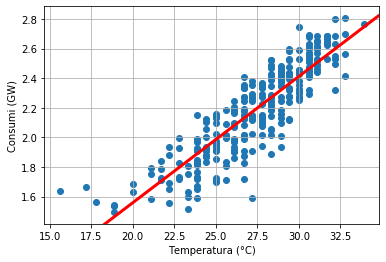

In [27]:
plot_model_on_data(X, y, lrm)

- Il grafico mostra come il modello lineare sia efficace nell'approssimare la distribuzione dei dati

## Divisione tra training e validation set

- Abbiamo visto come addestrare un modello di predizione su un set di dati e validarlo calcolandone diverse metriche **basandosi sugli stessi dati**
- Per verificare se un modello generalizza correttamente i dati su cui è addestrato, è importante **validarlo su dati diversi**
- Il metodo _hold-out_ prevede di dividere i dati a disposizione in
  - un _training set_ su cui addestrare il modello
  - un _validation set_ su cui calcolare le metriche di accuratezza del modello addestrato
- La proporzione tra training e validation set è arbitraria, possono essere ad es. 50-50 e 66-33

- Avendo dati in ordine cronologico, è comune utilizzare quelli più antecedenti come training set e quelli più recenti come validation
- In questo caso scegliamo di utilizzare i dati del 2015 come training set e quelli del 2016 e 2017 come validation set
- Definiamo un array booleano che indichi quali dati fanno parte del training set...

In [28]:
is_train = data_summer.index.year < 2016

- ...e lo usiamo per selezionare i dati del training e del validation set
  - l'operatore `~` esegue il NOT elemento per elemento

In [29]:
summer_train = data_summer.loc[is_train]
summer_val = data_summer.loc[~is_train]

## Esercizio 1: Addestramento e validazione modello

- **(1a)** Creare ed addestrare un modello di regressione lineare sul training set `summer_train`
- **(1b)** Stampare le metriche di valutazione viste (MSE, errore relativo, R²) calcolate sullo stesso set
- **(1c)** Stampare le stesse metriche calcolate sul validation set `summer_val`
- **(1d)** Mostrare il grafico del modello sovrapposto al training set
- **(1e)** Mostrare il grafico del modello sovrapposto al validation set

## Analisi dell'intero anno

- I modelli addestrati sopra sono addestrati e validati solamente sui mesi estivi
- È possibile addestrare un modello utilizzabile per la predizione sull'intero anno?
- Iniziamo dividendo l'intero frame `data` in training e validation set ed estraiamo per ciascuno la matrice X e il vettore y

In [36]:
is_train = data.index.year < 2016
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

- Addestriamo un nuovo modello sul training set estratto

In [37]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- Validiamo il modello sia sullo stesso training set che sul validation set

In [38]:
print_eval(X_train, y_train, lrm)

   Mean squared error: 0.09687
       Relative error: 14.17653%
R-squared coefficient: 0.095711


In [39]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.097075
       Relative error: 15.39235%
R-squared coefficient: 0.095201


- In entrambi i casi, il modello è poco accurato: lo si deduce in particolare dal coefficiente R² vicino allo zero
- Visualizziamo il modello sovrapposto ai dati (training e validation insieme) per capire perché...

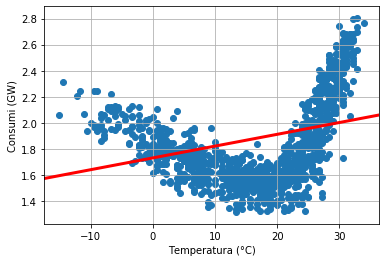

In [40]:
plot_model_on_data(data[["temp"]], data["demand"], lrm)

- Il grafico evidenzia che l'aumento dei consumi si ha sia nelle giornate più calde (a destra) che in quelle più fredde (a sinistra)
- Per questo il consumo non può essere approssimato dalla temperatura in modo soddisfacente con un unico modello lineare (una retta) per tutti i mesi dell'anno

## Regressione polinomiale

- La regressione _polinomiale_ è una generalizzazione di quella lineare in cui il modello include **termini di grado superiore**
- Ad esempio, mentre un modello di regressione lineare su una singola variabile $x$ (_univariata_) ha forma
$$ \hat{y}=\theta_0+\theta_1\cdot x $$
- in un modello polinomiale di secondo grado viene aggiunto un termine col quadrato della variabile, con un proprio coefficiente:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2 $$
- Analogamente, in un modello di terzo grado viene aggiunto un ulteriore termine col cubo della variabile:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2+\theta_3\cdot x^3 $$
- La regressione polinomiale corrisponde in pratica a quella lineare con l'aggiunta di variabili derivate da quelle esistenti

- Addestriamo ad esempio un modello polinomiale di secondo grado
- Creiamo una matrice `X_train_sq` con i quadrati elemento per elemento di `X_train`

In [41]:
X_train_sq = X_train ** 2

- Usiamo quindi `hstack` per unire le due matrici $m\times 1$ in una $m\times 2$

In [42]:
X_train_d2 = np.hstack([X_train, X_train_sq])

- Abbiamo quindi un dataset con due variabili, dove la seconda è il quadrato della prima

In [43]:
X_train_d2[:4]

array([[  1.7 ,   2.89],
       [  2.2 ,   4.84],
       [ 14.4 , 207.36],
       [ 15.6 , 243.36]])

- Creiamo come al solito un modello di regressione lineare e addestriamolo con questi dati

In [44]:
prm = LinearRegression()
prm.fit(X_train_d2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- Possiamo già valutare il modello sul training set stesso

In [45]:
print_eval(X_train_d2, y_train, prm)

   Mean squared error: 0.032695
       Relative error: 7.81509%
R-squared coefficient: 0.69479


- Per valutarlo sul validation set, ricaviamo da esso (`X_val`) una matrice `X_val_d2` come fatto prima per il training set

In [46]:
X_val_d2 = np.hstack([X_val, X_val ** 2])

In [47]:
print_eval(X_val_d2, y_val, prm)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


- Vediamo che questo modello con l'aggiunta del termine di secondo grado è molto più accurato di quello lineare

## Esercizio 2: Regressione polinomiale di terzo grado

- **(2a)** Creare una matrice `X_train_d3` con tre colonne contenenti rispettivamente i valori di `X_train`, i quadrati e i cubi
- **(2b)** Creare una matrice simile `X_val_d3` basata su `X_val`
- **(2c)** Addestrare un modello di regressione lineare su `X_train_d3`
- **(2d)** Stampare le metriche di valutazione del modello su `X_train_d3` e `X_val_d3`

## Feature polinomiali con scikit-learn

- Per applicare trasformazioni ai dati da fornire ai modelli, scikit-learn fornisce dei _filtri_ con un'interfaccia standard
- Ad esempio, per generare le variabili per la regressione polinomiale, usiamo il filtro `PolynomialFeatures`
- In modo simile ai modelli di predizione, un filtro va dapprima creato, impostandone eventuali parametri
- Il parametro più importante di `PolynomialFeatures` è `degree`, che indica il grado massimo delle feature da generare

In [54]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

- Come i modelli (es. `LinearRegression`), i filtri vanno "addestrati" con dei dati d'esempio prima di essere utilizzati 
  - nel caso di `PolynomialFeatures`, l'addestramento serve solo a indicare il numero di variabili presenti nei dati in input
- Ad esempio, creiamo una matrice con due osservazioni (righe) di una generica variabile (colonna) $X$

In [55]:
sample = np.array([ [ 2],
                    [-3] ])

- Passiamo ora questa matrice al metodo `fit`: il filtro apprende che i dati sono composti da una singola variabile

In [56]:
poly.fit(sample)

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

- Una volta addestrato, possiamo usare il metodo `transform` del filtro per trasformare qualsiasi matrice compatibile, ovvero con una sola colonna
- Trasformiamo ad esempio la stessa matrice usata in `fit`

In [57]:
poly.transform(sample)
#        X^0   X^1   X^2   X^3

array([[  1.,   2.,   4.,   8.],
       [  1.,  -3.,   9., -27.]])

- Dati i valori di $X$, il filtro ha restituito i valori di $X^0, X^1, X^2, X^3$
- I filtri forniscono un metodo `fit_transform` che raggruppa le due operazioni sopra
  - in pratica va usato `fit_transform` al primo utilizzo di un filtro e `transform` ai successivi

In [58]:
poly = PolynomialFeatures(degree=3)
poly.fit_transform(sample)

array([[  1.,   2.,   4.,   8.],
       [  1.,  -3.,   9., -27.]])

- La colonna $X^0$ ha sempre valore 1 ed è inutile nell'addestrare il modello, in quanto sarebbe ridondante con l'intercetta
- Possiamo escluderla impostando `include_bias=False` sul filtro

In [59]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[  2.,   4.,   8.],
       [ -3.,   9., -27.]])

- Per addestrare un modello polinomiale possiamo quindi creare il filtro per l'aggiunta delle feature, ad esempio di secondo grado...

In [60]:
poly = PolynomialFeatures(degree=2, include_bias=False)

- ...e addestrare un modello lineare con i dati trasformati

In [61]:
prm = LinearRegression()
X_train_sq = poly.fit_transform(X_train)
prm.fit(X_train_sq, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- In seguito, i valori della _x_ dovranno sempre essere trasformati con lo stesso filtro, utilizzando il metodo `transform`
- Ad esempio, per ottenere i consumi predetti a fronte di temperature di -5 °C, 5 °C e 25 °C...

In [62]:
sample = [ [-5], [5], [25] ]
sample_sq = poly.transform(sample)
prm.predict(sample_sq)

array([2.0611981 , 1.6400669 , 1.96642686])

- Per ottenere invece le metriche d'accuratezza...

In [63]:
X_val_sq = poly.transform(X_val)
print_eval(X_val_sq, y_val, prm)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


## Pipeline

- Ad ogni interazione col modello `prm` sopra dobbiamo esplicitamente trasformare i dati in ingresso col filtro `poly`
- scikit-learn permette di integrare uno o più filtri con un modello creando una **_pipeline_**
- Una volta costruita, la pipeline offre la **stessa API del modello** di predizione incapsulato, ma **applica automaticamente i filtri** ai dati prima di passarli al modello
  - chiamando `fit`, i filtri sono addestrati e applicati (`fit_transform`) sui dati di addestramento
  - chiamando `predict` (o `score`), i filtri già tarati sono applicati ai nuovi dati (`transform`)
- Ad esempio, per incapsulare il modello polinomiale visto sopra in un oggetto unico, usiamo una pipeline con il filtro `PolynomialFeatures` e il modello lineare
  - al costruttore va passata la lista dei componenti **in ordine di applicazione**, ciascuno rappresentato da una tupla con nome e componente

In [64]:
from sklearn.pipeline import Pipeline
prm = Pipeline([
    # nome     elemento
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

- Possiamo ora eseguire le stesse operazioni vista sopra sul modello, ma con la trasformazione dei dati applicata in automatico

In [65]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linreg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [66]:
prm.predict([ [-5], [5], [25] ])

array([2.0611981 , 1.6400669 , 1.96642686])

In [67]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


- Tramite l'attributo `named_steps` della pipeline possiamo accedere ai singoli componenti
  - funziona come un dizionario le cui chiavi sono i nomi assegnati ai componenti nel costruttore

In [68]:
prm.named_steps.keys()

dict_keys(['poly', 'linreg'])

- Possiamo ad esempio reperire il modello di regressione lineare `linreg`...

In [69]:
prm.named_steps["linreg"]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- ...e vedere i pesi assegnati alle due variabili, nell'ordine X e X²

In [70]:
prm.named_steps["linreg"].coef_

array([-0.04211312,  0.0019477 ])

## Curva del modello polinomiale

- Visualizzando il modello polinomiale di secondo grado in un grafico, vediamo che ha la forma di una funzione $a\cdot x^2+b\cdot x+c$, ovvero una parabola

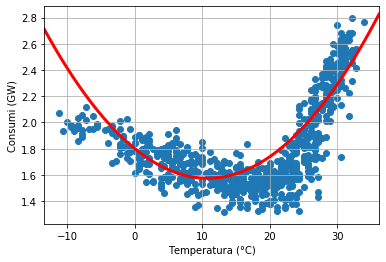

In [71]:
plot_model_on_data(X_val, y_val, prm)

- Come anche confermato dalle misure di errore, questo modello approssima molto meglio il consumo in base alla temperatura rispetto a quello lineare

## Esercizio 3: Regressione polinomiale con pipeline

- **(3a)** Creare un modello di regressione polinomiale di terzo grado usando una pipeline come sopra
- **(3b)** Addestrare il modello sui dati di training
- **(3c)** Stampare le misure di accuratezza del modello calcolate sui dati di training e su quelli di validazione
- **(3d)** Visualizzare il grafico del modello sovrapposto ai dati di validazione

## Standardizzazione dei dati

- Data una variabile $X$ con media $\mu$ e deviazione standard $\sigma$, la sua versione "standard" è calcolata come
$$ Z = \frac{X-\mu}{\sigma} $$
- $Z$ mantiene la distribuzione dei dati di $X$, ma con media 0 e deviazione standard 1
- In presenza di più variabili con scale diverse, applicare la standardizzazione a ciascuna di esse è utile per uniformarne i valori
- Questo può migliorare l'accuratezza dei modelli di regressione

- La standardizzazione si esegue col filtro `StandardScaler`
- Eseguendo `fit_transform` (o `fit`) il filtro memorizza medie e deviazioni standard dei dati passati
  - queste sono salvate negli attributi `mean_` e `var_`

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform([[0.001, 4000],
                      [0.002, 2500],
                      [0.004, 1000]])

array([[-1.06904497,  1.22474487],
       [-0.26726124,  0.        ],
       [ 1.33630621, -1.22474487]])

- Successivamente `transform` trasformerà ulteriori dati secondo medie e deviazioni memorizzate

In [79]:
scaler.transform([ [0.01, 100] ])

array([[ 6.14700856, -1.95959179]])

- Addestriamo un modello polinomiale di secondo grado come quello sopra, ma applicando la standardizzazione alle variabili $X$ e $X^2$
- Per far ciò, basta aggiungere il filtro alla pipeline

In [80]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),   # <- aggiunto
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

- Valutiamo l'accuratezza del modello

In [81]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


- In questo caso le metriche di accuratezza non sono cambiate standardizzando i dati
- Ma cosa succede con più variabili con ordini di grandezza molto diversi?

## Esercizio 4: Standardizzazione

- **(4a)** Addestrare sul training set un modello di regressione polinomiale di grado 15 (con variabili $X,X^2,\ldots,X^{15}$) e verificarne le misure di accuratezza sul validation set
- **(4b)** Ripetere il punto 4a, ma applicando la standardizzazione dei dati nel modello

Avendo a che fare con molte variabili di ordini di grandezza diversi, la standardizzazione contribuisce a migliorare l'accuratezza

## Regolarizzazione e regressione ridge

- Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da
$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$
- Per l'esattezza, la formula su cui si basa `LinearRegression` è
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$
- Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è
$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$
- Tuttavia, questo non garantisce l'accuratezza del modello in generale
- Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

- Addestriamo ad esempio un modello polinomiale di grado 30 con standardizzazione

In [85]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=30, include_bias=False,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

- Valutiamone le misure di accuratezza sia sul training set che sul validation set

In [86]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.019873
       Relative error: 5.96890%
R-squared coefficient: 0.81449


In [87]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.037238
       Relative error: 7.25381%
R-squared coefficient: 0.65292


- La differenza tra le misure suggerisce che il modello sia stato addestrato "troppo bene" sul training set ma non sia abbastanza generale (_overfitting_)

- A dimostrazione, si veda il grafico del modello sovrapposto ai dati del training set

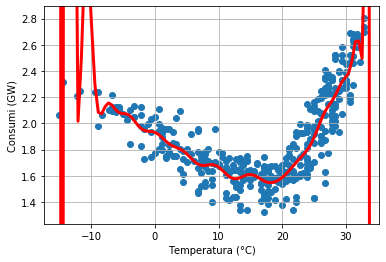

In [88]:
plot_model_on_data(X_train, y_train, prm)

- Soprattutto nella parte a sinistra, si nota che il modello è stato ottimizzato per minimizzare l'errore anche in casi estremi del training set

- Vediamo ora il modello sovrapposto al validation set

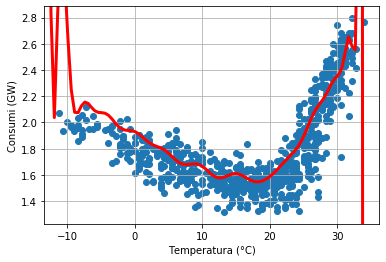

In [89]:
plot_model_on_data(X_val, y_val, prm)

- Si nota che nei casi estremi del validation set, diversi da quelli del training set, l'errore del modello è molto alto

- Vediamo quali sono i coefficienti del modello addestrato

In [90]:
prm.named_steps["linreg"].coef_

array([-2.23595400e-01, -4.99571633e+00, -1.26632250e+01,  8.41235258e+02,
       -5.57066217e+02, -5.27476432e+04,  1.10579204e+05,  1.60256172e+06,
       -5.30165688e+06, -2.43806927e+07,  1.22671804e+08,  1.35175046e+08,
       -1.52212842e+09,  1.05834081e+09,  9.71189651e+09, -2.06802756e+10,
       -2.06811500e+10,  1.19391934e+11, -9.12361939e+10, -2.39320109e+11,
        5.55146237e+11, -2.33579521e+11, -6.44723886e+11,  1.12872238e+12,
       -6.92328143e+11, -5.92376500e+10,  3.74457553e+11, -2.54811937e+11,
        7.94330780e+10, -1.00302519e+10])

- I coefficienti per i termini di grado più alto sono molto alti in valore assoluto (fino a ${10}^{12}$)
- Questo causa l'andamento irregolare del modello nei casi estremi e i conseguenti errori
- Come evitare che i coefficienti assumano tali valori?

- La **_regolarizzazione_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello
- Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri
  - in questo modo parametri molto alti in valore assoluto sono molto penalizzati
- La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$
- $\alpha$ è un parametro impostabile dall'utente che controlla il "peso" della regolarizzazione
  - tali parametri impostabili sono a volte detti _iperparametri_ per distinguerli dai parametri addestrabili del modello

- Per eseguire la regressione ridge usiamo un modello `Ridge`
- Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`
- Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [91]:
from sklearn.linear_model import Ridge
rrm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
rrm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=30, include_bias=False,
                                    interaction_only=False, order='C')),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

- Verifichiamo i coefficienti del modello addestrato

In [92]:
rrm.named_steps["linreg"].coef_

array([-0.31325676, -0.02583932,  0.16619334,  0.12873744,  0.15304114,
        0.10838303,  0.08446827,  0.04675489,  0.01952785, -0.00549028,
       -0.02267416, -0.03463496, -0.04084124, -0.0427362 , -0.04099736,
       -0.03668078, -0.03057249, -0.02344422, -0.01590952, -0.00848886,
       -0.00158713,  0.00448139,  0.00948767,  0.01327275,  0.01573763,
        0.01683213,  0.01654581,  0.01489957,  0.01193869,  0.00772681])

- Vediamo che questa volta sono tutti inferiori a 1 in valore assoluto, per effetto della regolarizzazione

- Con tali, coefficienti, il modello ha un comportamento regolare anche per casi estremi, come si può vedere dal grafico

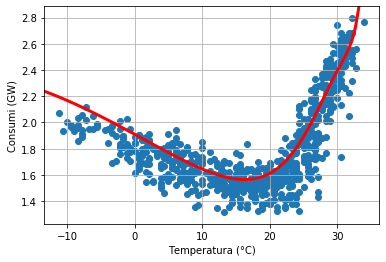

In [93]:
plot_model_on_data(X_val, y_val, rrm)

- Verifichiamo l'accuratezza su training e validation set

In [94]:
print_eval(X_train, y_train, rrm)

   Mean squared error: 0.020643
       Relative error: 6.14974%
R-squared coefficient: 0.8073


In [95]:
print_eval(X_val, y_val, rrm)

   Mean squared error: 0.024567
       Relative error: 6.91874%
R-squared coefficient: 0.77102


- Vediamo che le misure sul training set sono di poco peggiori, ma quelle sul validation set sono nettamente migliori

## Esercizio 5: Regressione polinomiale al variare di grado e regolarizzazione

- **(5a)** Definire una funzione `test_regression` con parametri `degree` e `alpha` che
  - definisca un modello di regressione polinomiale di grado `degree` con standardizzazione dei dati e regolarizzazione L2 con peso `alpha`
  - addestri tale modello sui dati `X_train`, `y_train`
  - restituisca il coefficiente R² del modello calcolato sui dati `X_val`, `y_val`
- **(5b)** Generare una lista, array o serie di valori restituiti dalla funzione con `alpha=0.01` e `degree` variabile con valori da 3 a 30
- **(5c)** Ripetere il punto 5b con `alpha=10`
- **(5d)** Visualizzare i risultati in un grafico a linea (`plt.plot`)

## Caso di studio 2: predizione dei prezzi delle case

- Riprendiamo dalla scorsa esercitazione il dataset relativo ai prezzi delle case
  - sono fornite informazioni (tasso criminalità, inquinamento, demografia, ...) su diversi quartieri
  - in base a queste va stimato per ciascuno il prezzo mediano delle abitazioni (`MEDV`)
- Forniamo tale dataset già adattato per essere caricato con `read_csv` con le opzioni di default

In [101]:
import os.path
if not os.path.exists("housing.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fjGjx", "housing.csv")

In [102]:
housing = pd.read_csv("housing.csv")

In [103]:
housing.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


## Divisione training-validation con scikit-learn

- Abbiamo visto il metodo _hold-out_ in cui i dati disponibili sono divisi in training e validation set
- scikit-learn fornisce un'apposita funzione `train_test_split` per suddividere casualmente un set di dati in due insiemi "train" e "test" disgiunti
  - il set di dati è una sequenza di elementi, es. array NumPy o serie/frame pandas
  - con l'opzione `test_size=X` si indica la proporzione (se X decimale tra 0 e 1) o il numero di elementi (se X intero) da inserire nel test piuttosto che nel train (default 0.25, ovvero 25\%)
  - con l'opzione `random_state` si indica un seed per la riproducibilità
- Ad esempio, dividiamo il frame `housing` in due parti `train_data` e `val_data`, contenenti rispettivamente 2/3 e 1/3 dei dati

In [104]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(housing, test_size=1/3, random_state=42)

- I due nuovi frame contengono due sottoinsiemi disgiunti delle righe di `housing`, mescolate casualmente

In [105]:
train_data.shape

(337, 14)

In [106]:
train_data.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
492,0.11132,0.0,27.74,0,0.609,5.983,83.5,2.1099,4,711.0,20.1,396.90,13.35,20.1
108,0.12802,0.0,8.56,0,0.520,6.474,97.1,2.4329,5,384.0,20.9,395.24,12.27,19.8


In [107]:
val_data.shape

(169, 14)

In [108]:
val_data.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
173,0.09178,0.0,4.05,0,0.510,6.416,84.1,2.6463,5,296.0,16.6,395.50,9.04,23.6
274,0.05644,40.0,6.41,1,0.447,6.758,32.9,4.0776,4,254.0,17.6,396.90,3.53,32.4
491,0.10574,0.0,27.74,0,0.609,5.983,98.8,1.8681,4,711.0,20.1,390.11,18.07,13.6


- A `train_test_split` possiamo passare **due (o più) collezioni** con pari numero di elementi per far sì che siano suddivise insieme, applicando **a tutte lo stesso ordine** casuale dei dati
- Ad esempio separiamo `housing` in due strutture dati allineate:
  - una serie y con i valori della variabile dipendente (`MEDV`)
  - un frame X con i valori delle variabili indipendenti (tutte le altre)

In [109]:
y = housing["MEDV"]
X = housing.drop(columns=["MEDV"])

- Applichiamo quindi `train_test_split` congiuntamente a X e y

In [110]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=1/3, random_state=42)

- Si può verificare dagli indici che l'ordine delle righe di `X_train` è lo stesso di `y_train` (lo stesso vale per `X_val` e `y_val`)

In [111]:
X_train.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15
492,0.11132,0.0,27.74,0,0.609,5.983,83.5,2.1099,4,711.0,20.1,396.90,13.35
108,0.12802,0.0,8.56,0,0.520,6.474,97.1,2.4329,5,384.0,20.9,395.24,12.27


In [112]:
y_train.head(3)

7      27.1
492    20.1
108    19.8
Name: MEDV, dtype: float64

In [113]:
np.array_equal(X_train.index, y_train.index)

True

- Addestriamo e valutiamo dapprima un modello lineare semplice

In [114]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 20.595
       Relative error: 16.20789%
R-squared coefficient: 0.72621


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione
  - i coefficienti si trovano in un array `lrm.coef_`
  - usiamo una serie per associarli ai nomi delle colonne corrispondenti
- Tuttavia, tali pesi dipendono molto dalla scala delle variabili

In [116]:
pd.Series(lrm.coef_, index=X_train.columns)

CRIM       -0.129470
ZN          0.037960
INDUS       0.060978
CHAS        3.213498
NOX       -16.499614
RM          3.911519
AGE        -0.012602
DIS        -1.427742
RAD         0.239546
TAX        -0.008180
PTRATIO    -0.935991
B           0.011948
LSTAT      -0.546562
dtype: float64

## Esercizio 6: Analisi coefficienti con standardizzazione

- **(6a)** Creare con una pipeline un modello di regressione lineare che applichi la standardizzazione ai dati in ingresso
- **(6b)** Addestrare il modello sui dati `X_train`, `y_train`
- **(6c)** Stamparne le misure di accuratezza calcolate su `X_val`, `y_val`
- **(6d)** Stampare come sopra i coefficienti del modello con nomi delle colonne associate

## k-Fold Cross Validation

- Il metodo _k-fold_ è un'alternativa al metodo hold-out per valutare l'accuratezza di un modello
  - i dati sono divisi causalmente in k gruppi (_fold_)
  - ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi
  - i risultati dei singoli test sono aggregati
- Per iniziare, definiamo gli oggetti `X` e `y` con i valori di variabili indipendenti e dipendente dell'intero dataset
  - non usiamo più le partizioni create con `train_test_split`

In [122]:
X = housing.drop(["MEDV"], axis=1)
y = housing["MEDV"]

- La classe `KFold` definisce oggetti che generano un dato numero di fold su un insieme di dati
  - esistono altre classi per generare fold in modi diversi, usate ad es. per dati divisi in gruppi
- Creiamo ad esempio un oggetto che genera 5 fold
  - dobbiamo specificare che i dati sono distribuiti casualmente e con quale seed

In [123]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

- Per eseguire la cross validation secondo un generatore di fold dato, scikit-learn fornisce la funzione `cross_validate`
- Gli input alla funzione `cross_validate` sono:
  - la definizione di un modello, di cui viene addestrata una copia con la stessa configurazione per ciascun fold
  - i dati, divisi come per `fit` in valori di variabili indipendenti (X) e dipendente (y)
  - l'oggetto che genera i fold dai dati, ad es. un'istanza di `KFold`
- Definiamo ad esempio un modello polinomiale di grado 2 con standardizzazione

In [124]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

- Utilizziamo la funzione `cross_validate` passando il modello, i dati e l'oggetto `KFold` definito sopra
  - `return_train_score=True` indica che vogliamo ottenere l'accuratezza di ciascun modello anche sul train set oltre che sul validation set

In [125]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y, cv=kf, return_train_score=True)

- Otteniamo un dizionario con un vettore per ciascuna misura estratta, ciascuno ha un valore per ogni fold

In [126]:
cv_result

{'fit_time': array([0.0209229 , 0.02735591, 0.0121789 , 0.01162195, 0.00843215]),
 'score_time': array([0.01728225, 0.00586557, 0.00206804, 0.00208831, 0.00223064]),
 'test_score': array([0.80558294, 0.78699438, 0.76305893, 0.91222428, 0.83023822]),
 'train_score': array([0.9409317 , 0.93635502, 0.93248495, 0.92682517, 0.93430016])}

- Per operare facilmente, raccogliamo i dati in un frame

In [127]:
cv_table = pd.DataFrame(cv_result)
cv_table

,fit_time,score_time,test_score,train_score
0,0.020923,0.017282,0.805583,0.940932
1,0.027356,0.005866,0.786994,0.936355
2,0.012179,0.002068,0.763059,0.932485
3,0.011622,0.002088,0.912224,0.926825
4,0.008432,0.002231,0.830238,0.934300


- Per ognuno dei 5 fold vediamo riportati
  - i secondi impiegati per l'addestramento (`fit_time`) e la validazione (`score_time`) del modello
  - lo score calcolato su training set (`train_score`) e validation set (`test_score`)
- Lo score è quello calcolato dal metodo `score` del modello, ovvero il coefficiente R²

- Per avere un dato generale sulla bontà del modello, possiamo calcolare media e deviazione standard degli score

In [128]:
cv_table[["train_score", "test_score"]].agg(["mean", "std"])

,train_score,test_score
mean,0.934179,0.819620
std,0.005179,0.057334


- Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello
- Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

## Esercizio 7: Regressione ridge polinomiale

- **(7a)** Definire un modello di regressione polinomiale di grado 2 con standardizzazione come sopra, ma con regolarizzazione L2 (ridge) con $\alpha=1$
- **(7b)** Effettuare la cross validation a 5 fold del modello (riutilizzare `kf`), usando come sopra tutti i dati in `X` e `y`
- **(7c)** Estrarre media e deviazione standard di R² sui 5 fold e confrontarla col modello senza regolarizzazione